# 네이버 영화리뷰 감성분석 도전하기

1)데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import tensorflow as tf
import os
from konlpy.tag import Mecab

In [2]:
#데이터 읽어보기
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


2) 데이터로 구성

이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있다.

이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작한다. 

data_loader 안에서는 다음을 수행해야 한다. 

* 데이터의 중복 제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* X_train, y_train, X_test, y_test, word_to_index 리턴

In [3]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
#문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수이다.
#단, 모든 문장은 <BOS>로 시작하는 것으로 하자
def get_encoded_sentence(sentence, word_to_index):
    return[word_to_index['<BOSS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

#여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

#숫자 벡터로 encoded된 문장을 원래대로 decode하는 함수이다.
def get_decoded_sentence(encoded_stence, index_to, word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])
#[1:]를 통해 <BOS>를 제외한다

#여러 개의 숫자 벡터로 encoded된 문장을 한꺼번에 원래대로 decode하는 함수이다
def get_decoded_sentences(encoded_senences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

3) 모델 구성을 위한 데이터 분석 및 가공

* 데이터셋 내 문장 길이 분포

In [6]:
#다운로드한 데이터 실제 예시를 확인
print(X_train[0]) #1번째 리뷰데이터
print('라벨: ', y_train[0]) #1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [7]:
total_data_text = list(X_train) +list(X_test)
#텍스트 데이터 문장 길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

#문장길이의 평균값, 최대값, 표준편차를 계산해본다.
print('문장길이 평균: ', np.mean(num_tokens))
print('문장길이 최대: ', np.max(num_tokens))
print('문장길이 표준편차: ', np.std(num_tokens))

문장길이 평균:  15.96940191154864
문장길이 최대:  116
문장길이 표준편차:  12.843571191092


* 적절한 최대 문장 길이

In [8]:
#예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


전체 문장의 93.43%가 문장 길이 41 안에 포함 되니 문장 길이는 41이 적절할 것 같다.

* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [9]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       value=word_to_index["<PAD>"],
                                                       padding = 'pre',
                                                       maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


padding에 pre 대신 post를 넣어 토큰 <PAD>를 뒤에 넣어줄 수도 있지만, RNN은 입력데이터가 순차적으로 처리되어, 가장 마지막 입력이 최종 state 값에 가장 영향을 많이 미치게 되기 때문에 <PAD>를 문장 앞에 넣도록 설정했다.

In [10]:
#문장 길이의 평균값, 최대값, 표준편차를 다시 출력하자
total_data_text = list(X_train) +list(X_test)
#텍스트 데이터 문장 길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

#문장길이의 평균값, 최대값, 표준편차를 계산해본다.
print('문장길이 평균: ', np.mean(num_tokens))
print('문장길이 최대: ', np.max(num_tokens))
print('문장길이 표준편차: ', np.std(num_tokens))

문장길이 평균:  41.0
문장길이 최대:  41
문장길이 표준편차:  0.0


4) 모델 구성 및 validation set 구성

5) 모델 훈련 개시

6) Loss, Accuracy 그래프 시각화

7) 학습된 Embedding 레이어 분석

8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

# 1. CNN 모델

4) 모델 구성 및 validation set 구성

In [11]:
vocab_size = 10000
word_vector_dim =16

#model 설계
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation = 'relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation = 'relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation= 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [12]:
# validation set 30000건 분리
x_val = X_train[:30000]
y_val = y_train[:30000]

# vailidation set을 제외한 나머지
partial_X_train = X_train[30000:]
partial_y_train = y_train[30000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(113432, 41)
(113432,)


5) 모델 훈련 개시

In [13]:
#모델 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 20 #결과 보면서 에포크 값 바꿔 여러번 시도해보기

history = model.fit(partial_X_train,
                   partial_y_train,
                   epochs = epochs,
                   batch_size = 512,
                   validation_data = (x_val, y_val),
                   verbose = 1)

Epoch 1/20
222/222 [==============================] - 4s 6ms/step - loss: 0.4937 - accuracy: 0.7557 - val_loss: 0.3597 - val_accuracy: 0.8433
Epoch 2/20
222/222 [==============================] - 1s 5ms/step - loss: 0.3319 - accuracy: 0.8591 - val_loss: 0.3425 - val_accuracy: 0.8515
Epoch 3/20
222/222 [==============================] - 1s 5ms/step - loss: 0.3005 - accuracy: 0.8735 - val_loss: 0.3383 - val_accuracy: 0.8547
Epoch 4/20
222/222 [==============================] - 1s 5ms/step - loss: 0.2768 - accuracy: 0.8870 - val_loss: 0.3409 - val_accuracy: 0.8551
Epoch 5/20
222/222 [==============================] - 1s 5ms/step - loss: 0.2521 - accuracy: 0.8991 - val_loss: 0.3479 - val_accuracy: 0.8549
Epoch 6/20
222/222 [==============================] - 1s 5ms/step - loss: 0.2247 - accuracy: 0.9126 - val_loss: 0.3609 - val_accuracy: 0.8528
Epoch 7/20
222/222 [==============================] - 1s 5ms/step - loss: 0.1936 - accuracy: 0.9279 - val_loss: 0.3876 - val_accuracy: 0.8501
Epoch 

In [14]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.8672 - accuracy: 0.8153
[0.8671936988830566, 0.8153060674667358]


6) Loss Accuracy 그래프 시각화

In [15]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


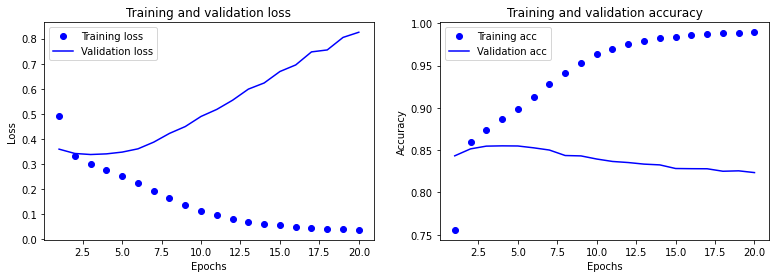

In [16]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(13,4))
ax1 = fig.add_subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


ax2 = fig.add_subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

training and validation accuracy 그래프와 training and validation loss의 그래프가 유사한 인사이트를 보이는 것을 알 수 있다.

7) 학습된 Embedding 레이어 분석

In [17]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [18]:
# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [19]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
vector

array([ 0.14599901,  0.04785056,  0.0633512 ,  0.05352214,  0.10417796,
        0.10989544,  0.05452868,  0.04634319, -0.05436319, -0.0176611 ,
        0.04959846,  0.13737562,  0.0527846 , -0.09338267,  0.05656209,
       -0.04031114], dtype=float32)

In [20]:
word_vectors.similar_by_word("사랑")

[('삶', 0.8975367546081543),
 ('꿀꿀', 0.8789502382278442),
 ('드릴게요', 0.8769569396972656),
 ('허각', 0.8766978979110718),
 ('돌고래', 0.8636221289634705),
 ('비춰', 0.8629289865493774),
 ('보듬', 0.8569116592407227),
 ('설명', 0.8528305888175964),
 ('부담없이', 0.8517491221427917),
 ('잼따', 0.8495585918426514)]

8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [21]:
import gensim
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['사랑']
vector     

/tmp/ipykernel_2421/1301037104.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['사랑']


array([-1.3740246 , -1.7353463 ,  3.3915305 , -2.569253  , -1.4016607 ,
        1.4556127 ,  0.9414557 ,  1.9207907 ,  0.16471806,  0.4838317 ,
       -0.8547181 ,  2.0879807 ,  0.86741775,  0.87539405, -0.09962013,
        0.22928311, -1.1858722 ,  0.00858838,  1.4999928 , -0.16196461,
       -0.35184434, -0.92390764,  1.0849575 ,  0.3025011 ,  2.7021565 ,
       -1.0263684 ,  0.32864776, -0.76589465, -2.510981  , -0.66225356,
        2.8434615 ,  0.50130975, -1.021874  , -1.4366034 ,  1.1110784 ,
        0.5812605 , -0.5830406 , -0.5785423 ,  1.3634988 ,  2.3074338 ,
       -1.4314893 ,  0.45745876,  1.1073523 , -3.2135262 , -0.2898375 ,
       -1.1622221 ,  1.2369208 , -0.7622987 , -0.37757635,  1.1376442 ,
        0.01065568, -0.69105595,  1.5159112 ,  1.1534518 , -1.0119992 ,
       -0.5757404 ,  1.1349088 , -1.1289831 ,  0.13004152,  2.0451715 ,
       -0.23940353,  1.3604902 ,  0.72700524,  0.32545742,  1.0612459 ,
        0.42252553,  1.1442151 ,  2.8774905 ,  2.4377263 , -1.34

In [23]:
word2vec.similar_by_word("사랑")

/tmp/ipykernel_2421/1360476464.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("사랑")


[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [25]:
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_2421/2178099375.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_2421/2178099375.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [26]:
#모델 설계

from tensorflow.keras.initializers import Constant

vocab_size = len(word_to_index)   # 어휘 사전의 크기
word_vector_dim = 200  # 워드 벡터의 차원수 

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(32))   
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(32, activation='relu',kernel_regularizer='l1'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                29824     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 2,030,913
Trainable params: 2,030,913
Non-trainable params: 0
_________________________________________________________________


In [28]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
222/222 [==============================] - 4s 9ms/step - loss: 1.2709 - accuracy: 0.7169 - val_loss: 0.5955 - val_accuracy: 0.8176
Epoch 2/20
222/222 [==============================] - 2s 7ms/step - loss: 0.4798 - accuracy: 0.8356 - val_loss: 0.4271 - val_accuracy: 0.8440
Epoch 3/20
222/222 [==============================] - 2s 7ms/step - loss: 0.4006 - accuracy: 0.8600 - val_loss: 0.3951 - val_accuracy: 0.8532
Epoch 4/20
222/222 [==============================] - 2s 7ms/step - loss: 0.3653 - accuracy: 0.8737 - val_loss: 0.3808 - val_accuracy: 0.8557
Epoch 5/20
222/222 [==============================] - 2s 7ms/step - loss: 0.3390 - accuracy: 0.8843 - val_loss: 0.3774 - val_accuracy: 0.8580
Epoch 6/20
222/222 [==============================] - 2s 7ms/step - loss: 0.3184 - accuracy: 0.8923 - val_loss: 0.3742 - val_accuracy: 0.8584
Epoch 7/20
222/222 [==============================] - 2s 7ms/step - loss: 0.3022 - accuracy: 0.8989 - val_loss: 0.3771 - val_accuracy: 0.8591
Epoch 

In [29]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4539 - accuracy: 0.8500
[0.45389771461486816, 0.8499908447265625]


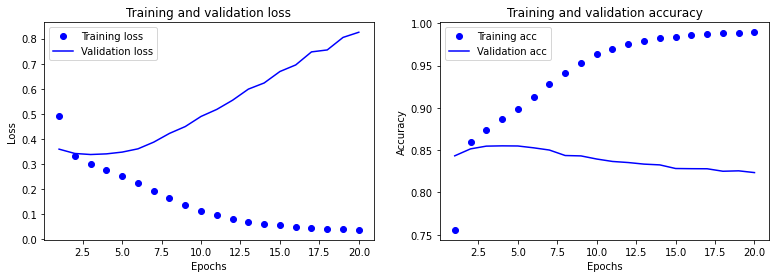

In [30]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(13,4))
ax1 = fig.add_subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


ax2 = fig.add_subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.5,1)
plt.legend()

plt.show()

training and validation accuracy 그래프와 training and validation loss의 그래프가 유사한 인사이트를 보이는 것을 알 수 있다.

# 2. RNN - LSTM 사용 모델

4) 모델 구성 및 validation set 구성

In [31]:
vocab_size = len(word_to_index)   # 어휘 사전의 크기
word_vector_dim = 128  # 워드 벡터의 차원수 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(32))   
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(16, activation='relu',kernel_regularizer='l1'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 1,301,153
Trainable params: 1,301,153
Non-trainable params: 0
_________________________________________________________________


In [32]:
# validation set 30000건 분리(20%)
x_val = X_train[:30000]
y_val = y_train[:30000]

# vailidation set을 제외한 나머지
partial_X_train = X_train[30000:]
partial_y_train = y_train[30000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(113432, 41)
(113432,)


5) 모델 훈련 개시

In [33]:
#모델 훈련
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
222/222 [==============================] - 3s 8ms/step - loss: 0.9441 - accuracy: 0.7871 - val_loss: 0.5316 - val_accuracy: 0.8480
Epoch 2/20
222/222 [==============================] - 1s 7ms/step - loss: 0.4368 - accuracy: 0.8604 - val_loss: 0.4043 - val_accuracy: 0.8524
Epoch 3/20
222/222 [==============================] - 1s 7ms/step - loss: 0.3700 - accuracy: 0.8753 - val_loss: 0.3872 - val_accuracy: 0.8533
Epoch 4/20
222/222 [==============================] - 1s 7ms/step - loss: 0.3397 - accuracy: 0.8857 - val_loss: 0.3841 - val_accuracy: 0.8550
Epoch 5/20
222/222 [==============================] - 1s 6ms/step - loss: 0.3154 - accuracy: 0.8952 - val_loss: 0.3873 - val_accuracy: 0.8524
Epoch 6/20
222/222 [==============================] - 1s 7ms/step - loss: 0.2931 - accuracy: 0.9039 - val_loss: 0.4032 - val_accuracy: 0.8519
Epoch 7/20
222/222 [==============================] - 1s 7ms/step - loss: 0.2731 - accuracy: 0.9116 - val_loss: 0.4026 - val_accuracy: 0.8514
Epoch 

In [34]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.5379 - accuracy: 0.8365
[0.537905216217041, 0.8365441560745239]


6) Loss Accuracy 그래프 시각화

In [35]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


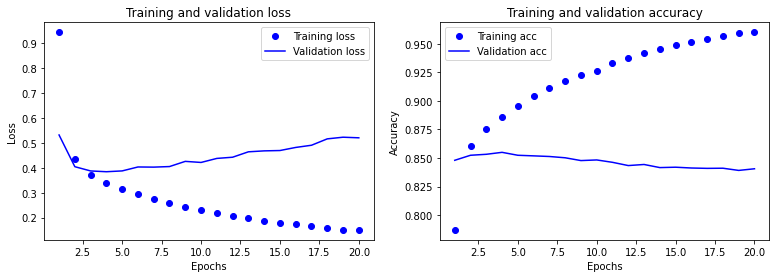

In [36]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(13,4))
ax1 = fig.add_subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


ax2 = fig.add_subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

training and validation accuracy 그래프와 training and validation loss의 그래프가 유사한 인사이트를 보이는 것을 알 수 있다.

7) 학습된 Embedding 레이어 분석

In [37]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 128)


In [39]:
# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [40]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
vector

array([-3.70950624e-02, -1.08354390e-01,  1.03170387e-01, -5.55503108e-02,
        1.05891980e-01,  1.44272953e-01, -6.75157309e-02, -1.80264071e-01,
       -1.25563174e-01,  9.06160474e-02, -7.43226334e-02, -4.83017974e-02,
       -2.30158772e-02,  7.41983354e-02, -7.89436102e-02, -7.16280937e-02,
       -7.74644911e-02, -6.75873309e-02, -1.79855004e-01,  9.99740791e-03,
        1.24896020e-01, -7.24446476e-02, -1.18221313e-01, -6.74475506e-02,
        6.66082129e-02, -7.23127052e-02, -3.97547670e-02, -2.46066023e-02,
        2.16108747e-02, -7.20127746e-02, -1.04175918e-01,  2.65143644e-02,
        1.77050382e-02,  5.35532758e-02, -5.56737892e-02,  1.26571134e-01,
       -1.02721848e-01,  8.89796242e-02,  6.82858452e-02,  2.92653348e-02,
       -2.33933497e-02,  5.87518374e-03,  4.67070192e-02, -2.00756729e-01,
        1.57789479e-03, -6.80804998e-02,  6.22432567e-02,  9.33034420e-02,
        6.87241182e-02, -9.80333611e-02,  1.09467074e-01,  8.48470628e-02,
        5.86538352e-02, -

In [41]:
word_vectors.similar_by_word("사랑")

[('미니언', 0.8722897171974182),
 ('수준급', 0.8589898347854614),
 ('A', 0.8459334373474121),
 ('먹먹', 0.8422995805740356),
 ('데요', 0.8411542177200317),
 ('감동', 0.8409152030944824),
 ('완벽', 0.8403930068016052),
 ('뛰어넘', 0.8396650552749634),
 ('..)', 0.836934506893158),
 ('명품', 0.836887001991272)]

8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [42]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['사랑']
vector       

/tmp/ipykernel_2421/906898285.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['사랑']


array([-1.3740246 , -1.7353463 ,  3.3915305 , -2.569253  , -1.4016607 ,
        1.4556127 ,  0.9414557 ,  1.9207907 ,  0.16471806,  0.4838317 ,
       -0.8547181 ,  2.0879807 ,  0.86741775,  0.87539405, -0.09962013,
        0.22928311, -1.1858722 ,  0.00858838,  1.4999928 , -0.16196461,
       -0.35184434, -0.92390764,  1.0849575 ,  0.3025011 ,  2.7021565 ,
       -1.0263684 ,  0.32864776, -0.76589465, -2.510981  , -0.66225356,
        2.8434615 ,  0.50130975, -1.021874  , -1.4366034 ,  1.1110784 ,
        0.5812605 , -0.5830406 , -0.5785423 ,  1.3634988 ,  2.3074338 ,
       -1.4314893 ,  0.45745876,  1.1073523 , -3.2135262 , -0.2898375 ,
       -1.1622221 ,  1.2369208 , -0.7622987 , -0.37757635,  1.1376442 ,
        0.01065568, -0.69105595,  1.5159112 ,  1.1534518 , -1.0119992 ,
       -0.5757404 ,  1.1349088 , -1.1289831 ,  0.13004152,  2.0451715 ,
       -0.23940353,  1.3604902 ,  0.72700524,  0.32545742,  1.0612459 ,
        0.42252553,  1.1442151 ,  2.8774905 ,  2.4377263 , -1.34

In [43]:
word2vec.similar_by_word("사랑")

/tmp/ipykernel_2421/1360476464.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("사랑")


[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [44]:
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_2421/2178099375.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_2421/2178099375.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [45]:
vocab_size = len(word_to_index)   # 어휘 사전의 크기
word_vector_dim = 200  # 워드 벡터의 차원수 

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(32))   
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(32, activation='relu',kernel_regularizer='l1'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                29824     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 2,030,913
Trainable params: 2,030,913
Non-trainable params: 0
_________________________________________________________________


In [46]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
222/222 [==============================] - 3s 9ms/step - loss: 1.2633 - accuracy: 0.7248 - val_loss: 0.6008 - val_accuracy: 0.8179
Epoch 2/20
222/222 [==============================] - 2s 7ms/step - loss: 0.4790 - accuracy: 0.8339 - val_loss: 0.4246 - val_accuracy: 0.8462
Epoch 3/20
222/222 [==============================] - 2s 7ms/step - loss: 0.3991 - accuracy: 0.8608 - val_loss: 0.3948 - val_accuracy: 0.8533
Epoch 4/20
222/222 [==============================] - 2s 7ms/step - loss: 0.3631 - accuracy: 0.8742 - val_loss: 0.3835 - val_accuracy: 0.8566
Epoch 5/20
222/222 [==============================] - 2s 7ms/step - loss: 0.3397 - accuracy: 0.8845 - val_loss: 0.3775 - val_accuracy: 0.8590
Epoch 6/20
222/222 [==============================] - 2s 7ms/step - loss: 0.3199 - accuracy: 0.8920 - val_loss: 0.3748 - val_accuracy: 0.8588
Epoch 7/20
222/222 [==============================] - 2s 7ms/step - loss: 0.3020 - accuracy: 0.8997 - val_loss: 0.3771 - val_accuracy: 0.8590
Epoch 

In [47]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4368 - accuracy: 0.8465
[0.43684643507003784, 0.8465121984481812]


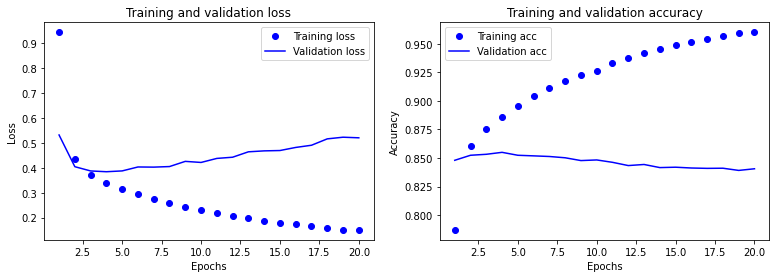

In [48]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(13,4))
ax1 = fig.add_subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


ax2 = fig.add_subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.5,1)
plt.legend()

plt.show()

training and validation accuracy 그래프와 training and validation loss의 그래프가 유사한 인사이트를 보이는 것을 알 수 있다.

# 3. GlobalMaxPooling1D() 하나만 사용한 모델

4) 모델 구성 및 validation set 구성

In [49]:
vocab_size = len(word_to_index)  
word_vector_dim = 128   

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(16, activation='relu',kernel_regularizer='l1'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                2064      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 1,282,081
Trainable params: 1,282,081
Non-trainable params: 0
_________________________________________________________________


In [50]:
# validation set 30000건 분리(20%)
x_val = X_train[:30000]
y_val = y_train[:30000]

# vailidation set을 제외한 나머지
partial_X_train = X_train[30000:]
partial_y_train = y_train[30000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(113432, 41)
(113432,)


5) 모델 훈련 개시

In [51]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
222/222 [==============================] - 2s 5ms/step - loss: 1.3397 - accuracy: 0.7216 - val_loss: 0.6969 - val_accuracy: 0.7291
Epoch 2/20
222/222 [==============================] - 1s 4ms/step - loss: 0.6595 - accuracy: 0.7695 - val_loss: 0.5794 - val_accuracy: 0.8041
Epoch 3/20
222/222 [==============================] - 1s 4ms/step - loss: 0.5547 - accuracy: 0.8075 - val_loss: 0.5102 - val_accuracy: 0.8202
Epoch 4/20
222/222 [==============================] - 1s 4ms/step - loss: 0.5078 - accuracy: 0.8235 - val_loss: 0.4808 - val_accuracy: 0.8272
Epoch 5/20
222/222 [==============================] - 1s 4ms/step - loss: 0.4832 - accuracy: 0.8294 - val_loss: 0.4629 - val_accuracy: 0.8311
Epoch 6/20
222/222 [==============================] - 1s 4ms/step - loss: 0.4643 - accuracy: 0.8359 - val_loss: 0.4498 - val_accuracy: 0.8345
Epoch 7/20
222/222 [==============================] - 1s 4ms/step - loss: 0.4504 - accuracy: 0.8406 - val_loss: 0.4410 - val_accuracy: 0.8362
Epoch 

In [52]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4057 - accuracy: 0.8436
[0.4057328701019287, 0.8435624837875366]


6) Loss Accuracy 그래프 시각화

In [53]:
history_dict = history.history
print(history_dict.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


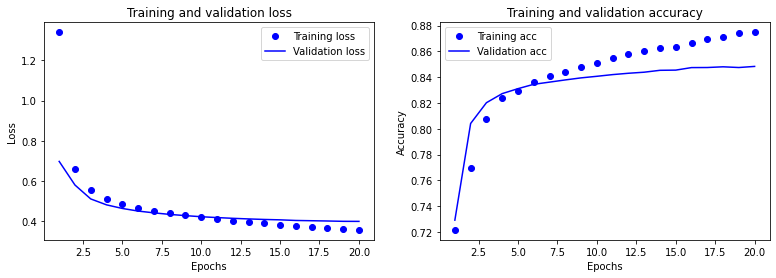

In [54]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(13,4))
ax1 = fig.add_subplot(1,2,1)
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim(-1, 1.5)
plt.legend()
ax2 = fig.add_subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.5,1)
plt.legend()

plt.show()

training and validation accuracy 그래프와 training and validation loss의 그래프가 유사한 인사이트를 보이는 것을 알 수 있다.

7) 학습된 Embedding 레이어 분석

In [55]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 128)


In [56]:
# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [57]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
vector

array([-0.04978008, -0.02389147, -0.01022691, -0.00616966, -0.01106902,
       -0.10893048, -0.133405  , -0.17059474, -0.00076323, -0.09933148,
       -0.04000279,  0.01686371, -0.27293444,  0.6769407 , -0.2546403 ,
        0.01422545,  0.11080753,  0.16039093, -0.2898064 ,  0.19987977,
       -0.12640601, -0.09549914, -0.01510958, -0.02706373, -0.23889293,
       -0.2345366 , -0.06006887, -0.27821   ,  0.34927997,  0.33658344,
       -0.11310714,  0.23805848, -0.04112872,  0.03816817, -0.28788066,
       -0.05019619, -0.01506845, -0.1588545 , -0.0223051 ,  0.1908673 ,
        0.47223362, -0.00977451, -0.13154523, -0.0462221 , -0.01359222,
       -0.03456553, -0.03588679, -0.10795703, -0.01437637, -0.03648931,
        0.01815459, -0.04399839, -0.12158689, -0.27336088, -0.19369087,
        0.24978101,  0.33491778,  0.01588557, -0.281184  , -0.24351487,
       -0.02332733,  0.37055936, -0.07767235, -0.2489767 , -0.05738611,
       -0.29053736, -0.03500063, -0.02146347, -0.26872122, -0.06

In [58]:
word_vectors.similar_by_word("사랑")

[('왕조현', 0.6937699913978577),
 ('주군', 0.6838071942329407),
 ('마법', 0.6810615658760071),
 ('핫', 0.667174220085144),
 ('애인', 0.6651933789253235),
 ('순수', 0.6640225052833557),
 ('릴리', 0.6590795516967773),
 ('미남', 0.6563628911972046),
 ('로빈윌리엄스', 0.6511014103889465),
 ('결혼식', 0.6502306461334229)]

8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [59]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['사랑']
vector       

/tmp/ipykernel_2421/906898285.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['사랑']


array([-1.3740246 , -1.7353463 ,  3.3915305 , -2.569253  , -1.4016607 ,
        1.4556127 ,  0.9414557 ,  1.9207907 ,  0.16471806,  0.4838317 ,
       -0.8547181 ,  2.0879807 ,  0.86741775,  0.87539405, -0.09962013,
        0.22928311, -1.1858722 ,  0.00858838,  1.4999928 , -0.16196461,
       -0.35184434, -0.92390764,  1.0849575 ,  0.3025011 ,  2.7021565 ,
       -1.0263684 ,  0.32864776, -0.76589465, -2.510981  , -0.66225356,
        2.8434615 ,  0.50130975, -1.021874  , -1.4366034 ,  1.1110784 ,
        0.5812605 , -0.5830406 , -0.5785423 ,  1.3634988 ,  2.3074338 ,
       -1.4314893 ,  0.45745876,  1.1073523 , -3.2135262 , -0.2898375 ,
       -1.1622221 ,  1.2369208 , -0.7622987 , -0.37757635,  1.1376442 ,
        0.01065568, -0.69105595,  1.5159112 ,  1.1534518 , -1.0119992 ,
       -0.5757404 ,  1.1349088 , -1.1289831 ,  0.13004152,  2.0451715 ,
       -0.23940353,  1.3604902 ,  0.72700524,  0.32545742,  1.0612459 ,
        0.42252553,  1.1442151 ,  2.8774905 ,  2.4377263 , -1.34

In [60]:
word2vec.similar_by_word("사랑")

/tmp/ipykernel_2421/1360476464.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("사랑")


[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [61]:
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_2421/2178099375.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_2421/2178099375.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [62]:
vocab_size = len(word_to_index)   # 어휘 사전의 크기
word_vector_dim = 200  # 워드 벡터의 차원수 

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(16, activation='relu',kernel_regularizer='l1'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 200)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                3216      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 2,003,233
Trainable params: 2,003,233
Non-trainable params: 0
_________________________________________________________________


In [63]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
222/222 [==============================] - 2s 6ms/step - loss: 1.8977 - accuracy: 0.5131 - val_loss: 0.8274 - val_accuracy: 0.5262
Epoch 2/20
222/222 [==============================] - 1s 5ms/step - loss: 0.7226 - accuracy: 0.5545 - val_loss: 0.6978 - val_accuracy: 0.5418
Epoch 3/20
222/222 [==============================] - 1s 5ms/step - loss: 0.6942 - accuracy: 0.5785 - val_loss: 0.6799 - val_accuracy: 0.6385
Epoch 4/20
222/222 [==============================] - 1s 5ms/step - loss: 0.6844 - accuracy: 0.6009 - val_loss: 0.6669 - val_accuracy: 0.6573
Epoch 5/20
222/222 [==============================] - 1s 5ms/step - loss: 0.6728 - accuracy: 0.6247 - val_loss: 0.6413 - val_accuracy: 0.7161
Epoch 6/20
222/222 [==============================] - 1s 5ms/step - loss: 0.6573 - accuracy: 0.6451 - val_loss: 0.6188 - val_accuracy: 0.7313
Epoch 7/20
222/222 [==============================] - 1s 5ms/step - loss: 0.6394 - accuracy: 0.6715 - val_loss: 0.5966 - val_accuracy: 0.7469
Epoch 

In [64]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4484 - accuracy: 0.8177
[0.44841814041137695, 0.8177065253257751]


Loss Accuracy 그래프 시각화

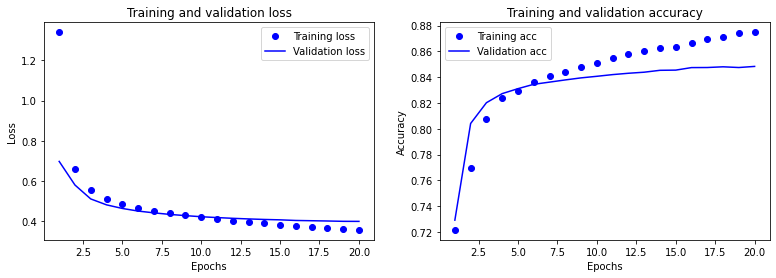

In [65]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(13,4))
ax1 = fig.add_subplot(1,2,1)
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim(-1, 1.5)
plt.legend()
ax2 = fig.add_subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.5,1)
plt.legend()

plt.show()

training and validation accuracy 그래프와 training and validation loss의 그래프가 유사한 인사이트를 보이는 것을 알 수 있다.

#### CNN 
- 한국어 Word2Vec 임베딩 전: loss: 0.8672 - accuracy: 0.8153
 - 단어 [사랑]에 대한 유사단어 결과 : (삶, 꿀꿀, 드릴게요, 허각, 돌고래, 비춰, 보듬, 설명, 부담없이, 잼따)
- 한국어 Word2Vec 임베딩 후: loss: 0.4539 - accuracy: 0.8500
 - 단어 [사랑]에 대한 유사단어 결과 : (슬픔, 행복, 절망, 기쁨, 이별, 추억, 인생, 애정, 연인, 유혹)


#### LSTM 
- 한국어 Word2Vec 임베딩 전: loss: 0.5379 - accuracy: 0.8365
 - 단어 [사랑]에 대한 유사단어 결과 : (미니언, 수준급, A, 먹먹, 데요, 감동, 완벽, 뛰어넘, ..), 명품)
- 한국어 Word2Vec 임베딩 후: loss: 0.4368 - accuracy: 0.8465
 - 단어 [사랑]에 대한 유사단어 결과 : (슬픔, 행복, 절망, 기쁨, 이별, 추억, 인생, 애정, 연인, 유혹)

#### GlobalMaxPooling1D
- 한국어 Word2Vec 임베딩 전: loss: 0.4057 - accuracy: 0.8436
 - 단어 [사랑]에 대한 유사단어 결과 : (왕조현, 주군, 마법, 핫, 애인, 순수, 릴리, 미남, 로빈윌리엄스, 결혼식)
- 한국어 Word2Vec 임베딩 후: loss: 0.4484 - accuracy: 0.8177
 - 단어 [사랑]에 대한 유사단어 결과 : (슬픔, 행복, 절망, 기쁨, 이별, 추억, 인생, 애정, 연인, 유혹)


#### 세 모델의 한국어 Word2Vec 임베딩 전후의 loss값과 accuracy 값을 살펴보면, 
 * CNN과 LSTM은 loss와 accuracy가 좋은 쪽으로 증가했는데(loss는 낮아지고 accuracy는 높아지는)
 * GlobalMaxPooling1D 같은 경우는 loss이 커지고 accuracy 값이 낮아지면서 전체적인 성능이 저하 되었다.

세 모델 중에서 변화 폭이 가장 크게 나타난 모델은 CNN 모델로, 한국어 Word2Vec 임베딩 전에는 loss 값이 0.8672였는데 임베딩 후에는 0.4539로, 큰 변화를 보였다.
loss 값의 변화에 반해, accuracy는 상대적으로 작게 변화한 것을 알 수 있다.
상대적으로 작게 올랐으나, accuracy가 85퍼센트가 되었다!

#### 한국어 Word2Vec 임베딩 전의 '사랑'이라는 단어에 대한 유사단어 결과를 보면, 
 * (지극히 필자 기준임) 
 * CNN 모델에서는 사랑과 관련된 단어가 하나도 보이지 않는다. 
 * LSTM에서는 [먹먹, 감동, 완벽]이, 
 * GlobalMaxPooling1D에서는 [핫, 애인, 순수, 결혼식]으로 사랑과 연관지을 수 있는 단어가 보인다. 
 
 > 이러한 결과가 loss값, accuracy값에 영향을 받은 것 같다.
